In [2]:
import matplotlib.pyplot as plt
import pandas as pd
from typing import List, Dict
import re
import orjson as json
from collections import defaultdict
import numpy as np
from pprint import pprint

In [3]:
DPI=300

In [4]:
def parse_event(string: str):
    data = {}
    substrings = re.findall(r'\[.*?\]', string)
    for substring in substrings:
        substring = substring[1:-1]
        key, value = tuple(substring.split(':'))
        data[key.strip()] = value.strip()
    return data

def get_events_client(quiche_host_logs: str):
    data = {
        'topic': defaultdict(lambda: defaultdict(list)),
    }
    with open(quiche_host_logs, 'r') as f:
        lines = f.readlines()
    for line in lines:
        line = line.strip()
        if "[PARSE_EVENT]" in line:
            event = parse_event(line.split("[PARSE_EVENT]")[1])
            data['topic'][event['topic']][event['event']].append(event)
    return data


In [5]:
spin_data = get_events_client("../local_measurements/spin_client.log")
mutex_data = get_events_client("../local_measurements/client.log")

In [5]:
def get_locking_events(data: dict):
    return data['topic']['locking']

def plot_locking_events(ax: plt.Axes, data: dict):
    data = get_locking_events(data)
    labels, data_to_plot = [], []   
    for event_name, values in data.items():
        labels.append(event_name)
        data_to_plot.append([int(ev_data['value']) for ev_data in values if ev_data['type'] == 'duration'])
    for i in range(len(data_to_plot)):
        print(f"Event {labels[i]}")
        print(f"\t Mean: {np.mean(data_to_plot[i])} ns")
        print(f"\t Median: {np.median(data_to_plot[i])} ns")
        print(f"\t Std: {np.std(data_to_plot[i])} ns")
    ax.bar(labels, height=[np.mean(x) for x in data_to_plot], yerr=[np.std(x) for x in data_to_plot], capsize=4, zorder=3)
    ax.set_ylim(bottom=0)
    ax.set_xticklabels(labels, rotation=30)
    ax.grid(which='major', zorder=0, linestyle="dashed")
    ax.set_ylabel('Average Duration (ns)')

def plot_data(ax: plt.Axes, data, labels, title):
    ax.set_title(title)
    ax.boxplot(data, zorder=3, labels=labels)
    ax.set_yscale('log')
    ax.grid(which='major', zorder=0, linestyle="dashed")
    ax.set_ylabel('Average Duration (ns)')
    for label in ax.get_xticklabels():
        label.set_rotation(90)

def plot_compare_locking(spin_lock: dict, mutex: dict):
    fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(6, 4), dpi=DPI, layout="constrained")
    spin_lock = get_locking_events(spin_lock)
    mutex = get_locking_events(mutex)
    spin_labels = {}
    for event_name, values in spin_lock.items():
        spin_labels[event_name] = [int(ev_data['value']) for ev_data in values if ev_data['type'] == 'duration']

    mutex_labels = {}
    for event_name, values in mutex.items():
        mutex_labels[event_name] = [int(ev_data['value']) for ev_data in values if ev_data['type'] == 'duration']
    
    labels = [] 
    data_spins, data_mutex = [], []

    assert set(spin_labels.keys()) == set(mutex_labels.keys())

    for event in spin_labels.keys():
        labels.append(event)
        data_spins.append(spin_labels[event])
        data_mutex.append(mutex_labels[event])

    plot_data(axes[0], data_spins, labels=labels, title="Spin Locks")
    plot_data(axes[1], data_mutex, labels=labels, title="Mutex Locks")


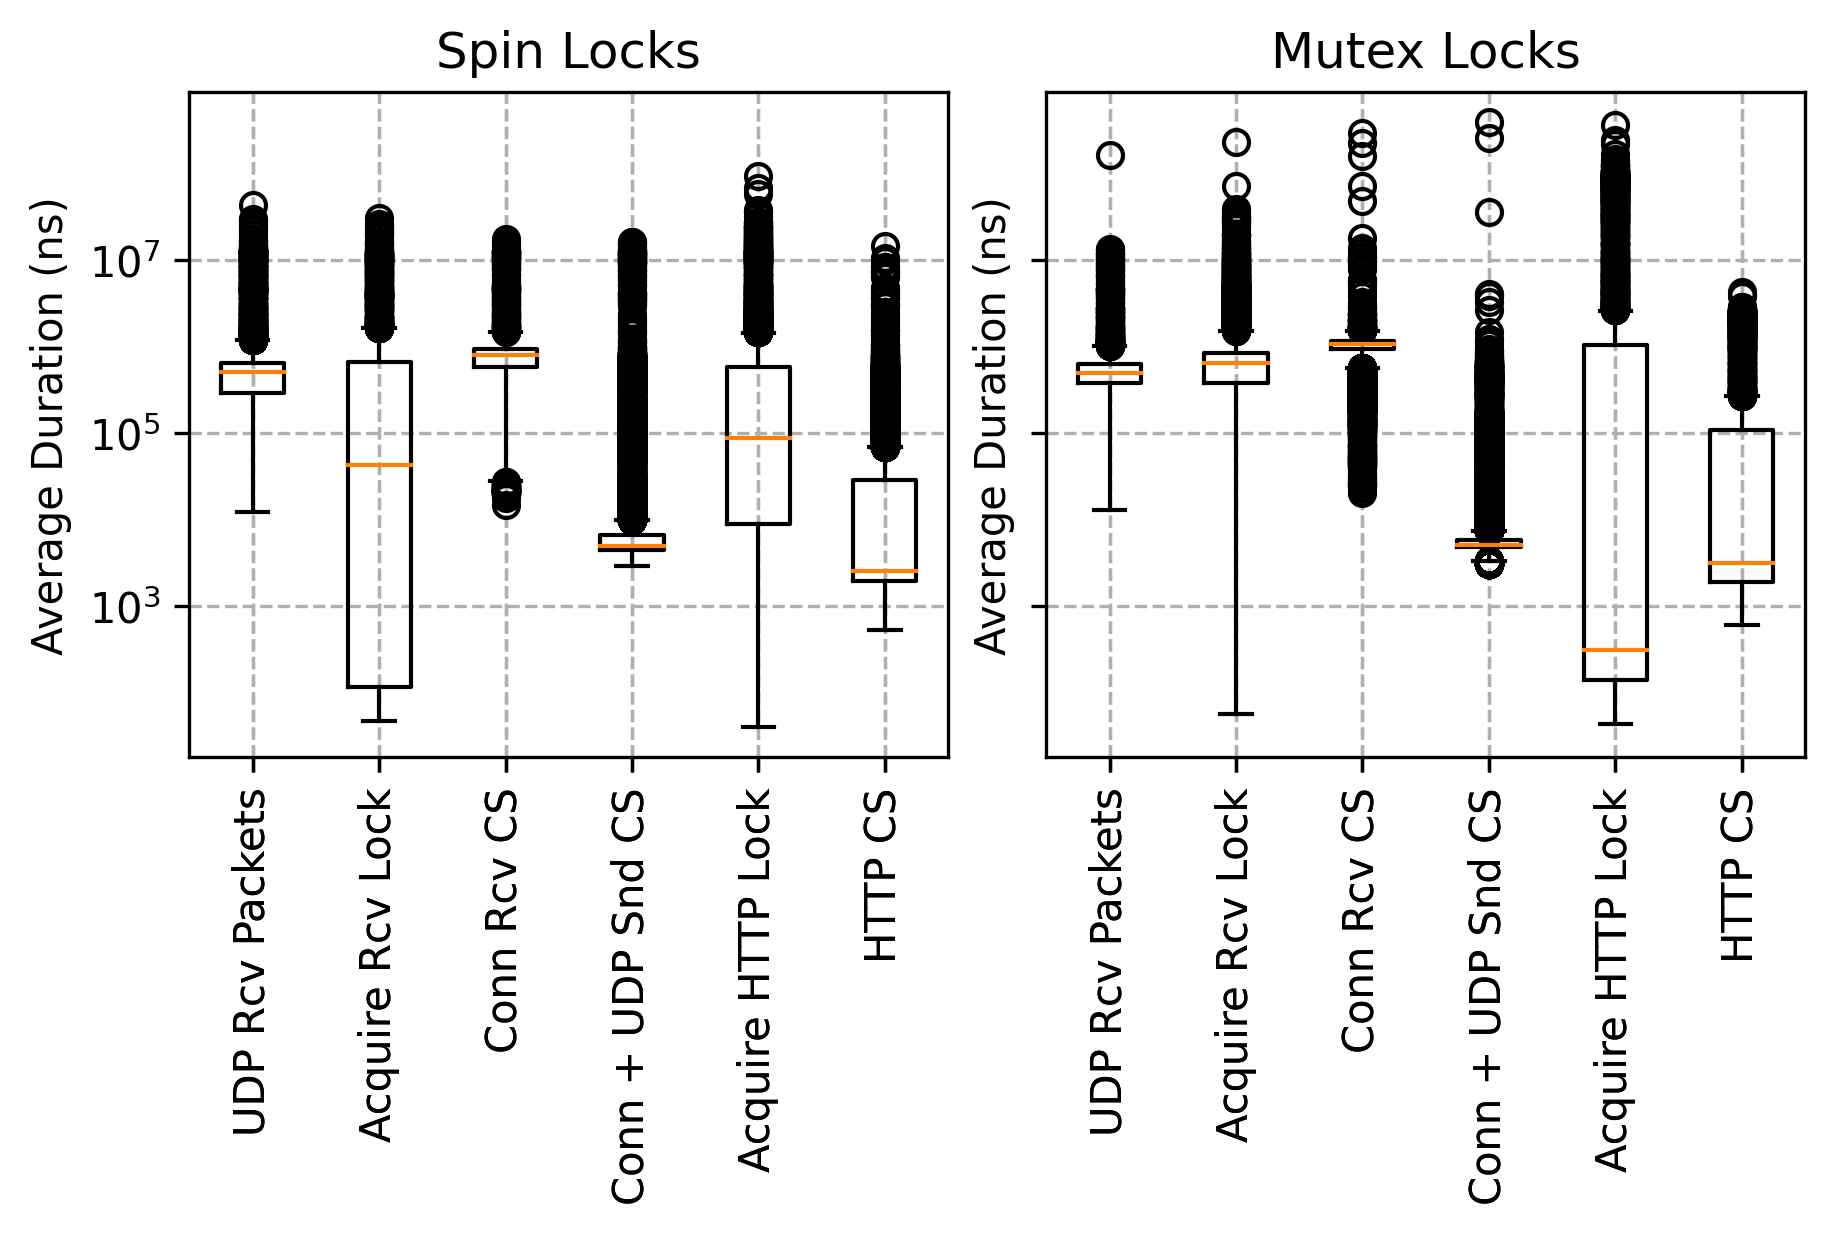

In [7]:
plot_compare_locking(spin_data, mutex_data)
plt.show()

In [15]:
for event, event_data in mutex_data['topic']['locking'].items():
    print(event, sum([int(ev_data['value']) for ev_data in event_data if ev_data['type'] == 'duration']) / 1_000_000_000)

UDP Rcv Packets 21.135916959
Acquire Rcv Lock 29.548696478
Conn Rcv CS 42.424594828
Conn + UDP Snd CS 5.800333728
Acquire HTTP Lock 47.879361223
HTTP CS 1.419586771


In [31]:
event_data = get_events_client("/home/vany/Desktop/school/2023_2024/thesis/quiche/apps/client.log")
event_data = get_locking_events(event_data)

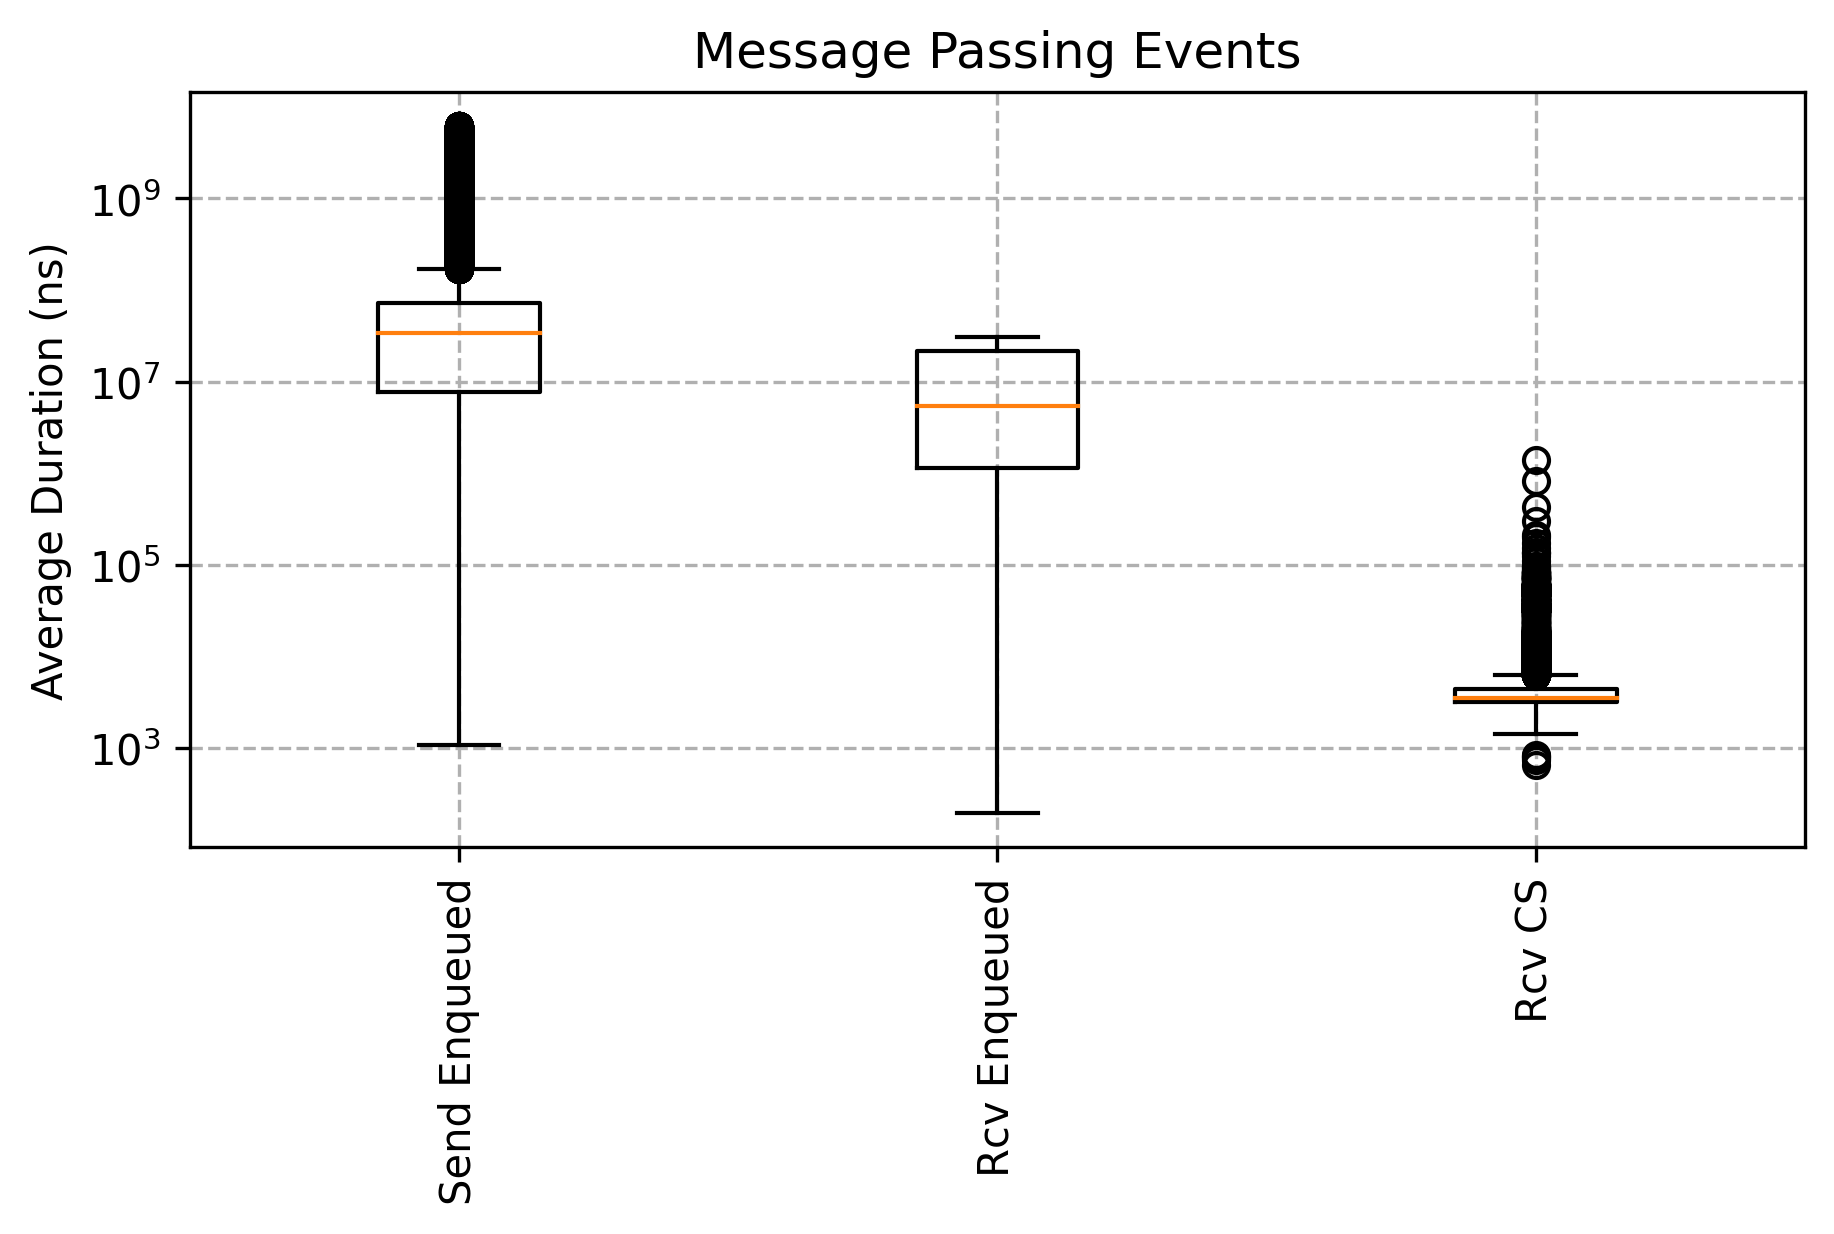

In [32]:
fig, ax = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(6, 4), dpi=DPI, layout="constrained")
labels = []
data = []
for event_name, values in event_data.items():
    data.append([int(ev_data['value']) for ev_data in values if ev_data['type'] == 'duration'])
    labels.append(event_name)
plot_data(ax, data, labels=labels, title="Message Passing Events")
plt.show()


In [33]:
for event, event_data in event_data.items():
    print(event, sum([int(ev_data['value']) for ev_data in event_data if ev_data['type'] == 'duration']) / 1_000_000_000)

Send Enqueued 34718.300683065
Rcv Enqueued 1702.456033698
Rcv CS 0.703260579
